Visualising the model output
======

For this section we'll need to import some plotting functions from elsewhere in the repository.

In [2]:
# First we need the system package sys
import sys
# The plotting functions are in the HMM folder
sys.path.append('../src/HMM')

In [3]:
# We'll look at four plots in this notebook
from hmm_plot_functions import plot_hmm_overtime, plot_hmm_quantify, plot_hmm_quantify_length, plot_hmm_raw

from misc import hmm_display

For this notebook we'll use a pre-trained HMM, as the dataset we used earlier was deliberately reduced in size to meet the github size limit and to minimise the time spent training. Due to this, there's a good chance the trained model might not end up with some qeird quirks, so to be safe we'll use one trained on the whole dataste.

In [4]:
# we'll need to load in the HMM from the data folder, it should be called example_hmm.pkl
import pickle

path  = ''

path = '/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/data/example_hmm.pkl'

h = pickle.load(open(path, "rb"))

We'll also need to set the labels for the decoded states and the colours we want to represent it.

In [5]:
hmm_labels = ['deep sleep', 'light sleep', 'quiet awake', 'active awake']
emission_labels = observables = ['immobile', 'micro', 'walking']
colours = ['darkblue', 'lightblue', 'orange', 'red']

# We can also view the pre-trained model
hmm_display(h, hmm_labels, emission_labels)

Starting probabilty table: 
|    |   deep sleep |   light sleep |   quiet awake |   active awake |
|----|--------------|---------------|---------------|----------------|
|  0 |    0.0165855 |   6.08132e-05 |      0.160616 |       0.822738 |

Transition probabilty table: 
|              |   deep sleep |   light sleep |   quiet awake |   active awake |
|--------------|--------------|---------------|---------------|----------------|
| deep sleep   |     0.834628 |     0.0101301 |     0.155242  |      0         |
| light sleep  |     0.112523 |     0.672489  |     0.214988  |      0         |
| quiet awake  |     0        |     0.25632   |     0.731348  |      0.0123321 |
| active awake |     0        |     0         |     0.0206226 |      0.979377  |

Emission probabilty table: 
|              |   immobile |     micro |   walking |
|--------------|------------|-----------|-----------|
| deep sleep   |  1         | 0         |  0        |
| light sleep  |  1         | 0         |  0       

In [6]:
# Now we can load in the data we used to train the model earlier, i.e. 'cleaned_data.pkl'
import pandas as pd 

# df = pd.read_pickle('')

df = pd.read_pickle('/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/admin/cleaned_data.pkl')

For plotting the data we'll be using [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) to create the plots. Many of your will be familiar with matplotlib which is long standing plotter in python. Seaborn acts ontop of matplotlib and alongside pandas, allowing users to quickly generate plots from a datafram with just 1 line of code. Head to the websites linked earlier to read more about their uses. For now we'll just be calling functions that utilise them in the backend, so they're won't be any explination to how the plots were generated.

Plots Overtime
====

One of the first things you want to look at with any time series analysis is how your output changes overtime. Below we'll generate a graph that plots the prevalence of each state over a 24 hour window.

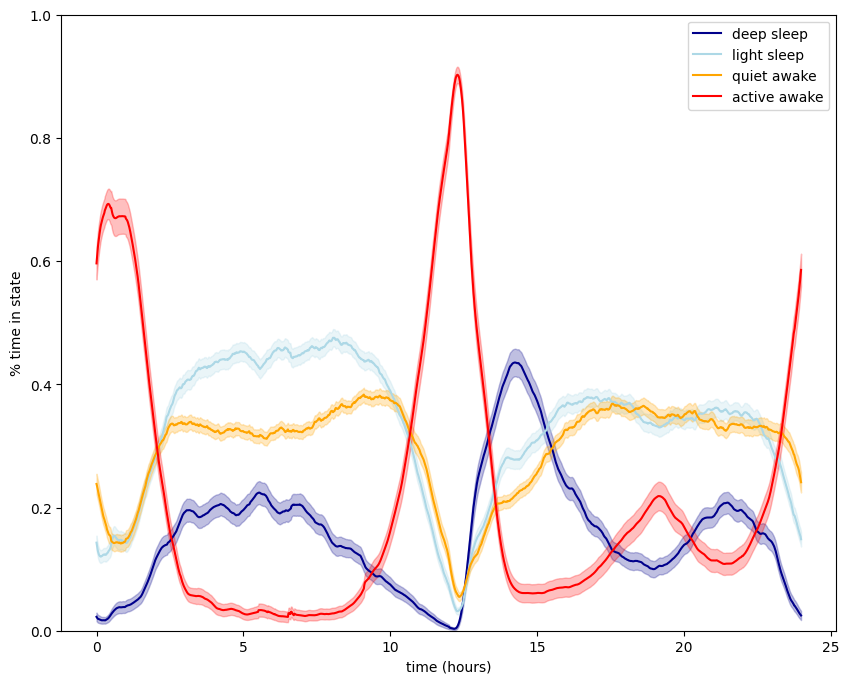

In [7]:
# The function below takes the data and the column to decode as the first 2 arguments
# wrapped takes the decoded data and transforms it to only be over 24 hours, rather than several days
# tbin is the time difference of the data that was used to train the model (here its 60). Make sure you remember the time difference when training future models as it can affect the output.
# avg_window is the amount of values that are included in a moving average window that smoothes the data for plotting
plot_hmm_overtime(data = df, variable = 'hmm', hmm = h, labels = hmm_labels, colours = colours, wrapped = True, tbin = 60, avg_window = 30)

Each plotted line for each state has the 95% confidence intervals shown in a semi-transparent colour around the line. Those sections of each line that have no overlapping confidence intervals we can be fairly sure that they are statistically significant from each other (although we would need to back this up with tests, but at a quick glance its good)

Comparing this plot to a regular sleep plot that uses the 5 minute rule to calculate sleep (the Drosophila standard, > 5 minutes of immobility equates sleep) we can see that the peaks in deep sleep follows directly the sleep pattern:

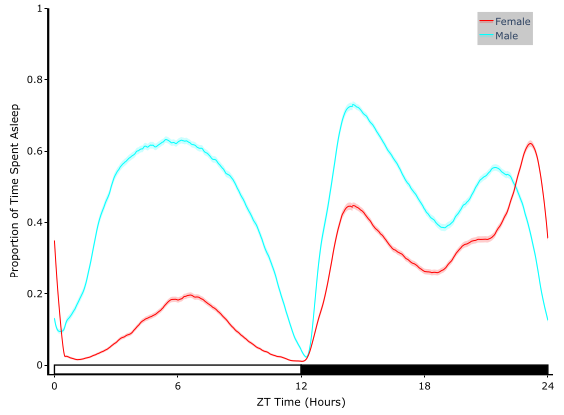

We can therefore be fairly happy that our HMM is replicating real life (or at least what we think is a correct interpretation of real life).

Now that we can see how the states change in prevelance overtime we'll want to quantify the values to see their proportions.

Quantifying plots
====

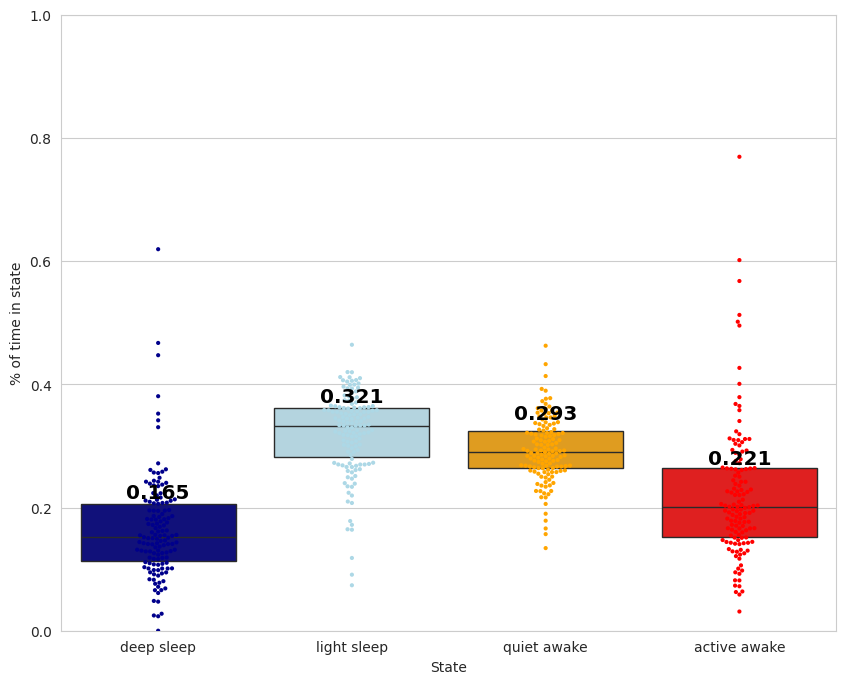

In [8]:
plot_hmm_quantify(data = df, hmm = h, variable = 'hmm', labels = hmm_labels, colours = colours, tbin = 60)

Quantifying length
======

/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 52.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/lab/Desktop/ReCoDE-HMMs-for-the-discovery-of-behavioural-states/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 25.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


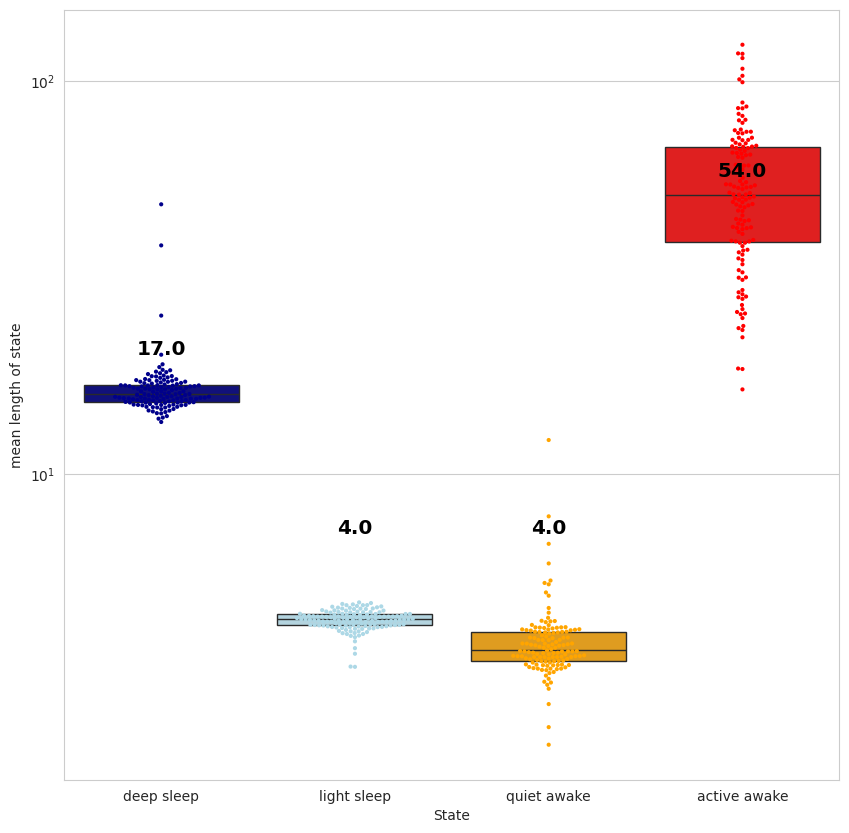

In [9]:
plot_hmm_quantify_length(data = df, hmm = h, variable = 'hmm', labels = hmm_labels, colours = colours, tbin = 60, func = 'max')

Plotting raw decoded data
====

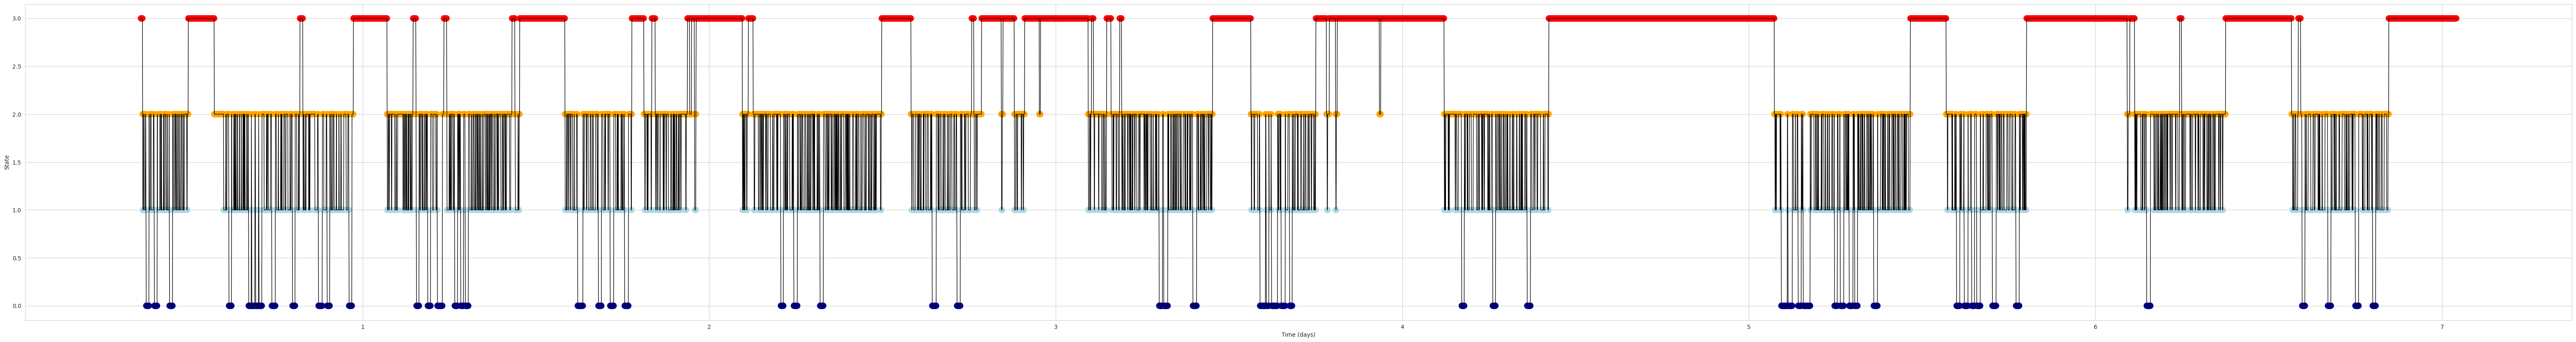

In [10]:
plot_hmm_raw(data = df, hmm = h, variable = 'hmm', colours = colours, tbin = 60, func = 'max')